<a href="https://colab.research.google.com/github/ByeonChanHO/Python-Practice/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nibabel tqdm scikit-image
#리눅스 사용 시 !을 쓴다.

In [ ]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.ndimage import zoom

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable

In [ ]:
#구글 드라이브를 쓰자
from google.colab import drive
#루트를 정해준다.
ROOT = "/content/drive"
print(ROOT)

drive.mount(ROOT) #we mount the google drive at /content/drive

#import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join


MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks'

print("MY_GOOGLE_DRIVE_PATH: ", MY_GOOGLE_DRIVE_PATH)

%cd "{MY_GOOGLE_DRIVE_PATH}"


/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MY_GOOGLE_DRIVE_PATH:  /content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


In [ ]:
#모델 작성하는 Pytoch에서 class는 모듈이다.
#SRNN 클래스 모델 선언 
class SRCNN(nn.Module):
  #모델이 어떤 layer을 쓰는냐
  #Conv2d(input채널,output채널, 필터 크기, 패딩 지정)
  #nn.Conv2d(64, 32, 1) convolution 사이즈가 1이기에 패딩 필요없다.
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 9, padding=4),
            nn.ReLU(),
            nn.Conv2d(64, 32, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 5, padding=2)
        )
    #하나의 x가 들어오면 init에서 정의한 것을 layer을 통과하는 방식으로 함수를 만든다
    def forward(self, x):
        return self.layers(x)

#FSRCNN
class FSRCNN(nn.Module):
  def __init__(self, scale_factor=1, num_channels=1, d=56, s=12, m=0):
    super(FSRCNN, self).__init__()
    #Feature Extraction
    self.fist_layers = nn.Sequential(
        nn.Conv2d(1,d,5, padding = 2),
        nn.PReLU(d),
    )
    #Shrinking
    self.mid_layers = [nn.Conv2d(d,s,1), nn.PReLU(s)]
    
    #Expanding
    for i in range(m):
      self.mid_layers.extend([nn.Conv2d(s,s,3,1), nn.PReLU(s)])
    self.mid_layers.extend([nn.Conv2d(s,d,1), nn.PReLU(d)])
    self.mid_layers = nn.Sequential(*self.mid_layers)

    #Deconvolution
    self.last_layers = nn.ConvTranspose2d(d,1,9,stride = scale_factor, 
                                          padding= 4, output_padding= scale_factor -1)
    
    self._initialize_weights()

  #공식 적용
  def _initialize_weights(self):
    for m in self.fist_layers:
      if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, 
                        std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
        nn.init.zeros_(m.bias.data)
    for m in self.mid_layers:
      if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, 
                        std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
        nn.init.zeros_(m.bias.data)
    nn.init.normal_(self.last_layers.weight.data, mean=0.0, std=0.001)
    nn.init.zeros_(self.last_layers.bias.data)

  def forward(self, x):
    x = self.fist_layers(x)
    x = self.mid_layers(x)
    x = self.last_layers(x)
    return x






In [ ]:
def preprocessing(image_name_raw):
  #nii파일을 nibabel으로 불러온다.
  raw_image = nib.load(image_name_raw)

  #get_fdata 다른 헤더정보도 가져온다.(여러정보)
  raw_array = np.array(raw_image.get_fdata(), dtype=np.float32)

  #전처리 99.9%보다 복셀들을 사용하도록하고 이상인것은 그냥 전기값으로 설정
  clip_value = np.sort(raw_array.ravel())[int(np.prod(raw_array.shape)*0.999)]
  clipped_image = np.clip(raw_array, 0, clip_value)

  #shape를 가져와 이미지 크기를 맞춰준다. 
  H, W, D = clipped_image.shape
  cropped_image = clipped_image[:H - H%3, :W - W%3, : D - D%3]
  image = cropped_image/ cropped_image.max()

  return image

In [ ]:
#다운 샘플링을 가지고 원본이미지에 가깝게 만들어준다.
def get_lr(image) :
  #1/3만큼 크기로 만든다..
  downscaled_lr = zoom(image, 1/3.0, order = 2, prefilter= False)

  #3만큼 올린다.
  lr = np.clip(zoom(downscaled_lr, 3, order = 2, prefilter=False), 0, image.max())
  return lr


In [ ]:
#dataset 클래스 정리
class BrainDataset(DataLoader):
  def __init__(self):
    #이미지를 불러와서 데이터 셋으로 만들겠다.
    self.dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'train_data')
    
    #list 로 만듬
    self.files_list = os.listdir(dataset_dir)

    #메모리에 lr과 hr 저장해오는것을 가져오기 위한 변수들.
    self.image_hr_list = []
    self.image_lr_list = []
    
#   for file_name in tqdm(self.files_list):
    for file_name in self.files_list:
      print(file_name)

      #데이터 셋에 있는 file_name을 가져온다
      image_name_raw = os.path.join(self.dataset_dir, file_name)

      #전처리
      image = preprocessing(image_name_raw)
      H, W, D = image.shape

      for i in range(H):
        #까만 이미지만 아니면 통과
        if np.any(image[i]):
          lr = get_lr(image[i])

          #배치 사이즈를 제일 앞에 두고 그다음 채널수를 앞에 두는데
          #채널이 중간에 엄청 많으니 새로 만드는 작업을 한다.
          self.image_hr_list.append(image[i,np.newaxis, :, :])
          self.image_lr_list.append(lr[np.newaxis, :, :])

  def __getitem__(self, index): #몇번째 데이터를 리턴해라이다.
    return self.image_lr_list[index], self.image_hr_list[index]
  def __len__(self): #몇번째 index가 있느냐
    return len(self.image_hr_list)



In [ ]:
#dataset을 표시해준다.
dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'train_data')
print(os.listdir(dataset_dir))

['T1w_acpc_dc_restore_brain_100307.nii.gz', 'T1w_acpc_dc_restore_brain_100206.nii.gz', 'T1w_acpc_dc_restore_brain_101915.nii.gz', 'T1w_acpc_dc_restore_brain_100408.nii.gz', 'T1w_acpc_dc_restore_brain_102008.nii.gz', 'T1w_acpc_dc_restore_brain_101410.nii.gz', 'T1w_acpc_dc_restore_brain_100610.nii.gz', 'T1w_acpc_dc_restore_brain_101309.nii.gz', 'T1w_acpc_dc_restore_brain_101107.nii.gz', 'T1w_acpc_dc_restore_brain_101006.nii.gz']


In [ ]:
#cuda 0번 GPU쓴다
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#cuda가 있는지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cpu


In [ ]:
BATCH_SIZE = 16

In [ ]:
#데이터 셋을 가져오자
dataset = BrainDataset()

#데이터 셋을 기반으로 읽어드는 방식
#shuffle 은 한번 train 할때마다 섞어서 다시 학습
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

T1w_acpc_dc_restore_brain_100307.nii.gz
T1w_acpc_dc_restore_brain_100206.nii.gz
T1w_acpc_dc_restore_brain_101915.nii.gz
T1w_acpc_dc_restore_brain_100408.nii.gz
T1w_acpc_dc_restore_brain_102008.nii.gz
T1w_acpc_dc_restore_brain_101410.nii.gz
T1w_acpc_dc_restore_brain_100610.nii.gz
T1w_acpc_dc_restore_brain_101309.nii.gz
T1w_acpc_dc_restore_brain_101107.nii.gz
T1w_acpc_dc_restore_brain_101006.nii.gz


In [ ]:
#모델을 cuda로 보냄.
model = FSRCNN()
model.to(device)

FSRCNN(
  (fist_layers): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (mid_layers): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
    (2): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (3): PReLU(num_parameters=56)
  )
  (last_layers): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
)

In [ ]:
#Loss와 Optimizer을 가져온다Loss와 Optimizer을 가져온다.
criterion = nn.MSELoss()
# optimizer = optim.Adam([
#         {'params': model.fist_layers.parameters()},
#         {'params': model.mid_layers.parameters()},
#         {'params': model.last_layers.parameters(), 'lr': 0.001 * 0.1}
#     ], lr = 0.001) #모델의 파라메타 업데이트 lr을 0.001로 설정

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#모델 트레이닝
for epoch in range(10):
  print('epoch' + str(epoch +1))

  #데이터 로더에 있는 image_lr과 images_hr을 가져와 cuda에 넣는다.
  
  for (images_lr, images_hr) in dataloader:
    images_lr = images_lr.to(device)
    images_hr = images_hr.to(device)


    #optimizer 세팅
    optimizer.zero_grad()
    
    #모델에 입력값을 통과시킨다.
    output = model(images_lr)
    
    #결과 값을 실제 결과와 비교하여 loss 계산
    loss = criterion(images_hr, output)

    #backward로 loss 계산
    loss.backward()
    optimizer.step()

    print(loss.detach().cpu().numpy())


epoch1
0.12678827
0.06393378
0.0039689178
0.05429583
0.03471552
0.0072417445
0.0049509034
0.01693504
0.025968114
0.017710198
0.013035459
0.006459456
0.0032203966
0.0054572816
0.012645649
0.009587969
0.009268818
0.0039645196
0.0030464607
0.0037300985
0.006414762
0.006864545
0.0055661653
0.006575975
0.0042090416
0.0028716968
0.003970223
0.0052536153
0.0045963535
0.0047873305
0.003967557
0.0023608287
0.0031764605
0.004010369
0.0037955397
0.004015698
0.0034613013
0.0026157482
0.0028884455
0.0022731235
0.003489013
0.0035620427
0.0035403268
0.0024174051
0.0028813842
0.002800718
0.0030758132
0.0031309098
0.0024410086
0.0028024474
0.0030648068
0.0026157696
0.00287144
0.0021679392
0.003129626
0.0024530152
0.0022522195
0.0025974258
0.002504988
0.0028264155
0.0027355005
0.0023357589
0.0022924535
0.002570688
0.0026219436
0.0022370259
0.002543021
0.002204472
0.0026729654
0.0020928034
0.0024226904
0.0021556674
0.0017247308
0.0022122674
0.00231471
0.00220141
0.0020292976
0.001874466
0.0023813692
0.00

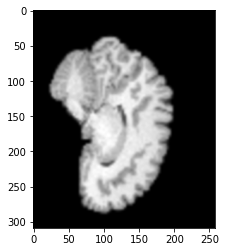

In [ ]:
#test data 를 가져온다.
image_name_raw_test = os.path.join('./srcnn/T1w_acpc_dc_restore_brain_102311.nii.gz')

#전처리를 한다.
image_test = preprocessing(image_name_raw_test)

#2D니깐 slice 하나를 가져온다.
hr_test_slice = image_test[110]
lr_test_slice = get_lr(hr_test_slice)
plt.imshow(lr_test_slice, cmap = 'gray')


In [ ]:
#학습한걸로 고쳐보자
model.eval()

image_test_tensor = ToTensor()(lr_test_slice)

#4D로 바꿔줘야한다.
image_test_tensor = torch.unsqueeze(image_test_tensor, 0)

image_test_tensor = image_test_tensor.to(device)
print(image_test_tensor.shape)


torch.Size([1, 1, 309, 258])


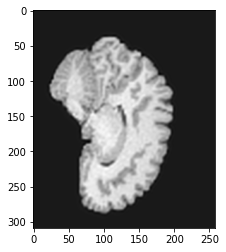

In [ ]:
output = model(image_test_tensor)
output_test_slice = output.detach().cpu().numpy()[0,0]
plt.imshow(output_test_slice, cmap = 'gray')

In [ ]:
print(peak_signal_noise_ratio(hr_test_slice, lr_test_slice), '\t', 
      peak_signal_noise_ratio(hr_test_slice, output_test_slice))
print(structural_similarity(hr_test_slice, lr_test_slice), '\t', 
      structural_similarity(hr_test_slice, output_test_slice))


27.56287227977571 	 28.36719366047552
0.9108224096353875 	 0.9308035369739012


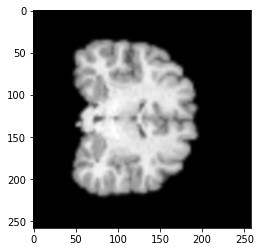

In [ ]:
hr_test_slice = image_test[:,160]
lr_test_slice = get_lr(hr_test_slice)
plt.imshow(lr_test_slice, cmap = 'gray')

torch.Size([1, 1, 258, 258])
27.44403734374643 	 28.331704427760343
0.914057841607277 	 0.9344199709354188


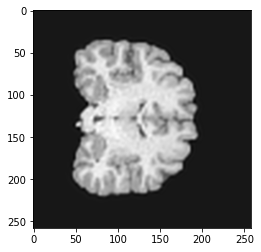

In [ ]:
image_test_tensor = ToTensor()(lr_test_slice)
image_test_tensor = torch.unsqueeze(image_test_tensor, 0)
image_test_tensor = image_test_tensor.to(device)
print(image_test_tensor.shape)
output = model(image_test_tensor)
output_test_slice = output.detach().cpu().numpy()[0,0]
plt.imshow(output_test_slice, cmap = 'gray')
print(peak_signal_noise_ratio(hr_test_slice, lr_test_slice), '\t', 
      peak_signal_noise_ratio(hr_test_slice, output_test_slice))
print(structural_similarity(hr_test_slice, lr_test_slice), '\t', 
      structural_similarity(hr_test_slice, output_test_slice))
